In [1]:
%pylab inline
from __future__ import print_function, division

import os
import os.path as osp
import matplotlib.pyplot as plt

from warnings import warn
import datetime, time
import glob as gb
from six import string_types
import argparse
import json
import time
import re

import numpy as np
import scipy.linalg as lin
import scipy.stats as sst


Populating the interactive namespace from numpy and matplotlib


In [2]:
import importlib
from smpce_data_to_corr import get_params
import utils._utils as ucr
import utils.setup_filenames as suf
import correlation2results as c2r
#import tests.test_smpce_data_to_corr as tts
np.set_printoptions(precision=3)

ucr = reload(ucr)
suf = reload(suf)
c2r = reload(c2r)

In [3]:
param_dir = osp.abspath('.')
assert param_dir == '/home/jb/code/simpace/simpace'
params = get_params(param_dir)

basedir = '/home/jb/data/simpace/data/rename_files'
resdir = osp.join(basedir, params['layout']['res']['dir'])
assert osp.isdir(resdir)

fp_anals = gb.glob(osp.join(resdir,'*'))
fp_anals = [f for f in fp_anals if osp.isdir(f)]
ke_anals = [osp.basename(fp_anals[idx]) for idx in range(len(fp_anals))]

pat = r"(.*)_\d\d\d\d_\d\d\d\d\d\d$" #_daymonth_hourminsec
p = re.compile(pat)
ke_anals = [p.match(strin).group(1) for strin in ke_anals if p.match(strin)]
fp_anals = [fp for fp in fp_anals if p.match(fp)]

assert set(['gr_minvox5', 'no_gr_minvox5']).issubset(set(ke_anals))
analrange = range(len(ke_anals))

print("directories found: \n" + "\n".join(fp_anals))
print("keys for analyses are : ",ke_anals)

directories found: 
/home/jb/data/simpace/data/rename_files/results/no_gr_minvox5_0604_004736
/home/jb/data/simpace/data/rename_files/results/gr_minvox5_0604_005252
keys for analyses are :  [u'no_gr_minvox5', u'gr_minvox5']


### Load correlation matrices

In [4]:
# find filenames for the different pipelines 
mtx = params['layout']['res']['corr']
mtxdir = [osp.join(fp_anals[idx], mtx) for idx in  analrange]
npz_anals = [gb.glob(osp.join(mtxdir[idx],"*"))[0] for idx in  analrange]
print("\n".join(npz_anals))

/home/jb/data/simpace/data/rename_files/results/no_gr_minvox5_0604_004736/corr_mtx/no_gr_minvox5.npz
/home/jb/data/simpace/data/rename_files/results/gr_minvox5_0604_005252/corr_mtx/gr_minvox5.npz


In [5]:
# choose pipeline in results
idx_pipeline = 0

conds_arr = np.load(npz_anals[idx_pipeline])['conds_arr'][()]
print(osp.basename(npz_anals[idx_pipeline]))
pipeline = ke_anals[idx_pipeline]
print("pipeline is: ", pipeline)


print(conds_arr['high'].shape)
nb_roi = conds_arr['high'].shape[-1]

for cond in c2r.ordered_conds(): # [none_c, low_c, med_c, high_c]:
    assert np.all(conds_arr[cond] <= 1.) and np.all(conds_arr[cond] >= -1.)
    
ordered_conds = c2r.ordered_conds
print(ordered_conds())

no_gr_minvox5.npz
pipeline is:  no_gr_minvox5
(11, 89, 89)
['none', 'low', 'med', 'high']


In [6]:
def smpce_mean_cond(cond_arr, cond):
    """ 
    Estimates the bias of each condition
    assumes that cond_arr['cond'] is (nb_of_sess, nb_roi, nb_roi)
    """
    # two last dimension must be indentical
    assert cond_arr[cond].shape[-1] == cond_arr[cond].shape[-2]  
    return cond_arr[cond].mean(axis=0)

    
def smpce_bias(cond_arr, ordered_conds):
    """ 
    Estimates the bias of each condition
    assumes that cond_arr['cond'] is (nb_of_sess, nb_roi, nb_roi)
    """
    
    assert ordered_conds[0] == 'none'
    estTrueC = smpce_mean_cond(cond_arr, 'none')
    bias = {}
    for ke in ordered_conds:
        bias[ke] = smpce_mean_cond(cond_arr, ke) - estTrueC
    
    return bias

def smpce_var(cond_arr, ordered_conds):
    """ 
    Estimates the variance of each condition
    assumes that cond_arr['cond'] is (nb_of_sess, nb_roi, nb_roi)
    """
    
    assert ordered_conds[0] == 'none'
    
    means = {}
    vari = {}
    for ke in ordered_conds:
        means[ke] = smpce_mean_cond(cond_arr, ke)
    for ke in ordered_conds:
        Cm = cond_arr[ke]
        vari[ke] = (Cm**2 - means[ke]).mean(axis=0)
        
    return vari
    

In [7]:
var_cond = smpce_var(conds_arr, ordered_conds())
bias_cond = smpce_bias(conds_arr, ordered_conds())
var_cond.keys()

['high', 'med', 'none', 'low']

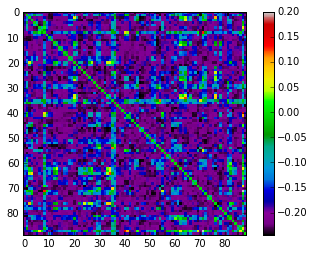

In [8]:
#imgshowed = plt.imshow(smpce_mean_cond(conds_arr, 'none'),aspect='equal', interpolation='nearest')
imgshowed = plt.imshow(var_cond['med'],aspect='equal', interpolation='nearest')
imgshowed.set_cmap('spectral')
_ = plt.colorbar()


In [9]:
for ke in bias_cond.keys():
    print(ke, ": ", lin.norm(bias_cond[ke]), lin.norm(var_cond[ke]))

high :  11.1141174508 17.3403547833
med :  9.21987899885 16.8765752432
none :  0.0 16.5782679582
low :  6.51113940496 16.3993051604


In [10]:
def print_bias_variance_from_npz(npz_anals):
    """
    """
    
    for npz_anal in npz_anals: 
        print("\nfrom analysis :", npz_anal, "\n")
        c_arr = np.load(npz_anal)['conds_arr'][()]
        v_cond = smpce_var(c_arr, ordered_conds())
        b_cond = smpce_bias(c_arr, ordered_conds())
        

        for ke in bias_cond.keys():
            print(ke, ": ", lin.norm(b_cond[ke]), lin.norm(v_cond[ke]))
            
        

In [11]:
del conds_arr
print_bias_variance_from_npz(npz_anals)


from analysis : /home/jb/data/simpace/data/rename_files/results/no_gr_minvox5_0604_004736/corr_mtx/no_gr_minvox5.npz 

high :  11.1141174508 17.3403547833
med :  9.21987899885 16.8765752432
none :  0.0 16.5782679582
low :  6.51113940496 16.3993051604

from analysis : /home/jb/data/simpace/data/rename_files/results/gr_minvox5_0604_005252/corr_mtx/gr_minvox5.npz 

high :  13.2733447912 17.2949739001
med :  10.3475136666 18.9868131149
none :  0.0 19.8929167609
low :  8.41730925882 19.8546789548
